## 1. importing packages

In [162]:
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as web
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from tensorflow.keras.callbacks import History
from tensorflow.keras import optimizers


## 2. overall configurations

In [2]:
%matplotlib inline


tqdm.pandas()
sns.set(style='whitegrid',palette='muted')
rcParams['figure.figsize'] = 14, 10

## 3. Getting the Data

In [22]:
import yfinance as yf
ticket = yf.Ticker('BOVA11.SA')
start = dt.datetime(2009, 1, 2) # First register data
end = dt.datetime(dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day - 1)

bova11 = ticket.history(interval= '1d', start = start, end = end).reset_index()
bova11

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3458,2022-12-09 00:00:00-03:00,104.230003,104.919998,103.389999,103.900002,5248949,0,0
3459,2022-12-12 00:00:00-03:00,103.750000,103.970001,100.300003,101.660004,7788574,0,0
3460,2022-12-13 00:00:00-03:00,102.260002,103.730003,100.019997,100.300003,16354218,0,0
3461,2022-12-14 00:00:00-03:00,99.300003,101.160004,98.300003,100.699997,15092220,0,0


In [23]:
len(bova11)

3463

## 4. Pre-processing

Adjust the columns name and type

In [24]:
bova11.columns = bova11.columns.str.lower()

In [25]:
bova11.date = pd.to_datetime(bova11.date)

In [26]:
bova11.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock splits    0
dtype: int64

Removing rows with volume 0

In [27]:
bova11 = bova11.loc[(bova11.volume != 0)].reset_index()
bova11.drop(columns='index', axis = 1, inplace = True)
bova11

,date,open,high,low,close,volume,dividends,stock splits
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0
...,...,...,...,...,...,...,...,...
3365,2022-12-09 00:00:00-03:00,104.230003,104.919998,103.389999,103.900002,5248949,0,0
3366,2022-12-12 00:00:00-03:00,103.750000,103.970001,100.300003,101.660004,7788574,0,0
3367,2022-12-13 00:00:00-03:00,102.260002,103.730003,100.019997,100.300003,16354218,0,0
3368,2022-12-14 00:00:00-03:00,99.300003,101.160004,98.300003,100.699997,15092220,0,0


Sorting the data by date

In [28]:
bova11 = bova11.sort_values(by='date').reset_index(drop=True)

Adding a column with the previous close value

In [29]:
bova11["prev_close"] = bova11.shift(1)["close"]

In [30]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999


Adding the close difference between dates

In [31]:
bova11["close_change"]= bova11.progress_apply(
    lambda row: 0 if np.isnan(row.prev_close) else row.close - row.prev_close,
    axis = 1
)

100%|██████████| 3370/3370 [00:00<00:00, 14691.86it/s]


In [32]:
bova11.head()

,date,open,high,low,close,volume,dividends,stock splits,prev_close,close_change
0,2009-01-02 00:00:00-02:00,38.279999,40.320000,37.939999,40.320000,119900,0,0,NaN,0.000000
1,2009-01-05 00:00:00-02:00,40.200001,42.000000,39.700001,42.000000,341700,0,0,40.320000,1.680000
2,2009-01-06 00:00:00-02:00,42.060001,42.320000,41.549999,42.320000,178300,0,0,42.000000,0.320000
3,2009-01-07 00:00:00-02:00,41.750000,41.770000,40.450001,40.639999,73400,0,0,42.320000,-1.680000
4,2009-01-08 00:00:00-02:00,40.150002,42.200001,40.150002,42.200001,195300,0,0,40.639999,1.560001


Checking the dataseries over time

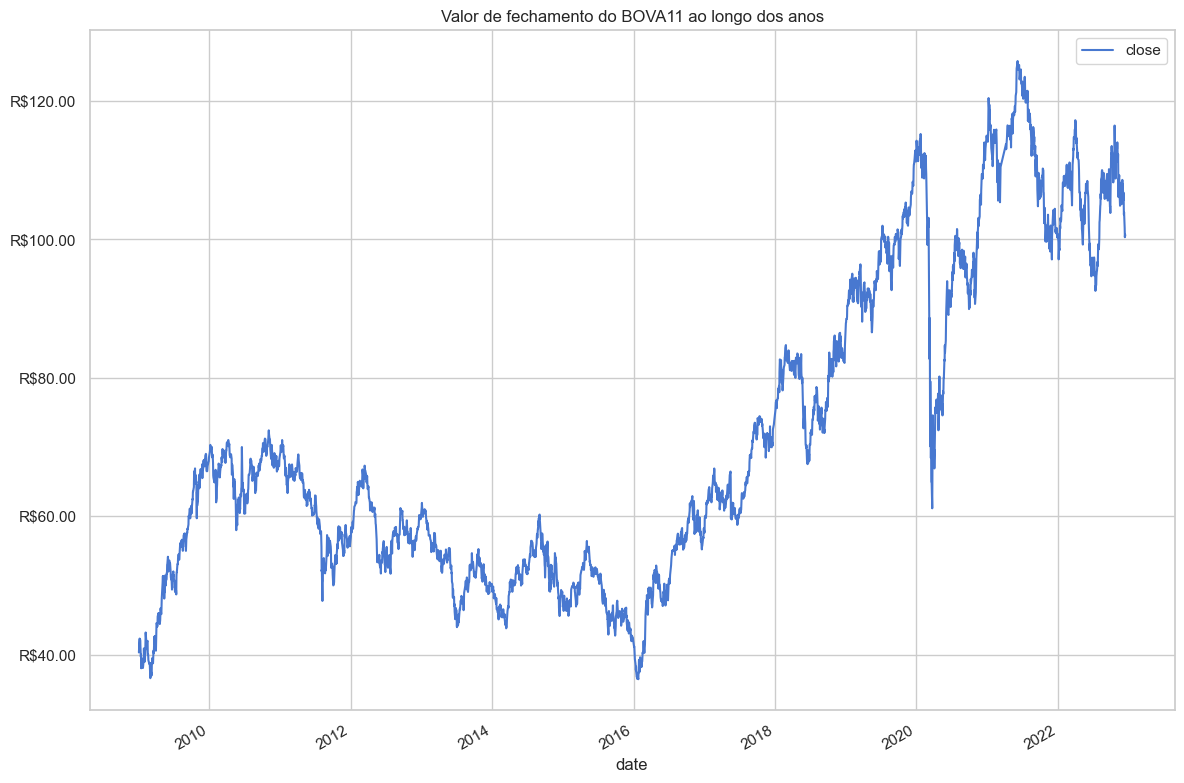

In [33]:
daily_closing = bova11[['date','close']]
daily_closing = daily_closing.set_index('date')
ax = daily_closing.plot()
plt.title('Valor de fechamento do BOVA11 ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

adding moving aveareges

In [34]:
bova11['ma_3d'] = bova11['close'].rolling(3, center = True, min_periods=1).mean()
bova11['ma_10d'] = bova11['close'].rolling(10, center = True,min_periods=1).mean()
bova11['ma_30d'] = bova11['close'].rolling(30, center=True, min_periods=1).mean()

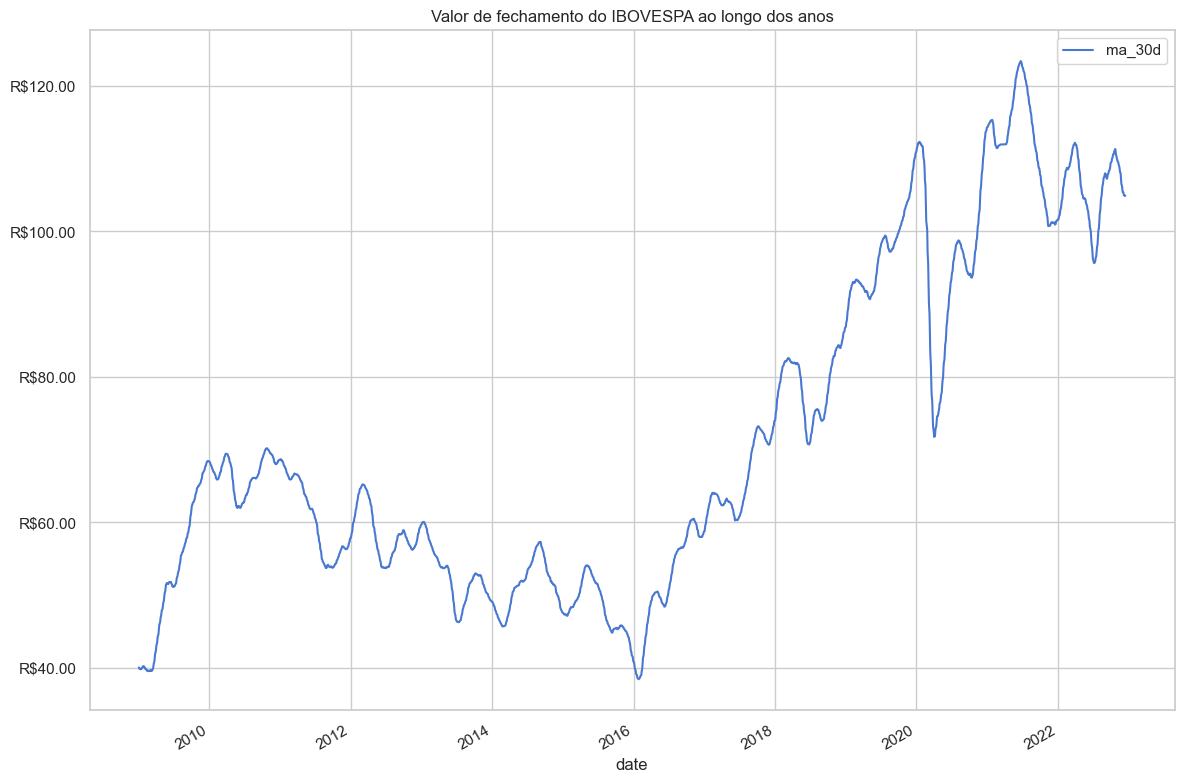

In [35]:
moving_avg = bova11[['date','ma_30d']]
moving_avg = moving_avg.set_index('date')
ax = moving_avg.plot()
plt.title('Valor de fechamento do IBOVESPA ao longo dos anos')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("R${x:,.2f}"))

Select the features and the predict columns

In [87]:
bova11.drop(['date', 'volume', 'dividends', 'stock splits', 'prev_close'],
            axis = 1,
           inplace = True)


In [89]:
bova11['target'] = bova11.close - bova11.open
bova11['targetClass'] = [1 if bova11.target[i] > 0 else 0 for i in range(len(bova11))]
bova11['targetNextClose'] = bova11['close'].shift(-1)

In [90]:
bova11.head()

,open,high,low,close,close_change,ma_3d,ma_10d,ma_30d,target,targetClass,targetNextClose
0,38.279999,40.320000,37.939999,40.320000,0.000000,41.160000,41.496000,40.072667,2.040001,1,42.000000
1,40.200001,42.000000,39.700001,42.000000,1.680000,41.546666,41.580000,39.948125,1.799999,1,42.320000
2,42.060001,42.320000,41.549999,42.320000,0.320000,41.653333,41.311429,39.892353,0.259998,1,40.639999
3,41.750000,41.770000,40.450001,40.639999,-1.680000,41.720000,41.147500,39.842223,-1.110001,0,42.200001
4,40.150002,42.200001,40.150002,42.200001,1.560001,41.613333,40.801111,39.897895,2.049999,1,42.000000


In [91]:
scaler = MinMaxScaler(feature_range = (-1, 1))
bova11_scaled = scaler.fit_transform(bova11)
print(bova11_scaled)

[[-0.39030025 -0.91719676 -0.95032594 ... -0.78570428  1.
  -0.8756999 ]
 [-0.35971966 -0.87970094 -0.91076644 ... -0.79239236  1.
  -0.86853306]
 [-0.33009474 -0.87255889 -0.86918409 ... -0.83530725  1.
  -0.90615904]
 ...
 [ 0.62873302  0.49804714  0.44504377 ... -0.89717146 -1.
   0.43896969]
 [ 0.58158801  0.44068748  0.40638354 ... -0.80353922  1.
   0.43449048]
 [ 0.59178152  0.46389903  0.43447974 ... -0.82694723  1.
          nan]]


Select the features and prediction target columns

In [94]:
backcandles = 100
X = []
for j in range(8): # range is the number of feature columns you will use
    X.append([])
    for i in range(backcandles, bova11_scaled.shape[0]):
        X[j].append(bova11_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(bova11_scaled[backcandles:, -1]) # Chosing the last column as the pred. target
y = np.reshape(yi, (len(yi), 1))

X.shape, y.shape

((3270, 100, 8), (3270, 1))

Split the train and test data

In [96]:
splitlimit = int(len(X) * 0.9)
X_train, X_test = X[:splitlimit], X[splitlimit+1:]
y_train, y_test = y[:splitlimit], y[splitlimit+1:]

### 4. Creating the model

In [99]:
def create_lstm_model(backcandles, num_features):
    lstm_input = Input(shape = (backcandles, num_features), name = 'lstm_input')
    inputs = LSTM(150, name = 'first_layer')(lstm_input)
    inputs = Dense(1, name = 'dense_layer')(inputs)
    output = Activation('linear', name = 'output')(inputs)
    model = Model(inputs = lstm_input, outputs = output)
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss = 'mse')
    return model

In [ ]:
model = create_lstm_model(100, 8)
model.fit(x = X_train, y = y_train, batch_size = 15, epochs = 30, shuffle = True, validation_split = 0.1)

### 5. Making predictions

In [103]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

11/11 [==============================] - 1s 43ms/step
[0.72379583] [0.7856663]
[0.7170287] [0.76103027]
[0.713917] [0.73863386]
[0.7044342] [0.7547593]
[0.69861734] [0.69540877]
[0.6900951] [0.69406486]
[0.6768409] [0.72519604]
[0.66885316] [0.62665177]
[0.65961593] [0.68107507]
[0.6471842] [0.6445688]


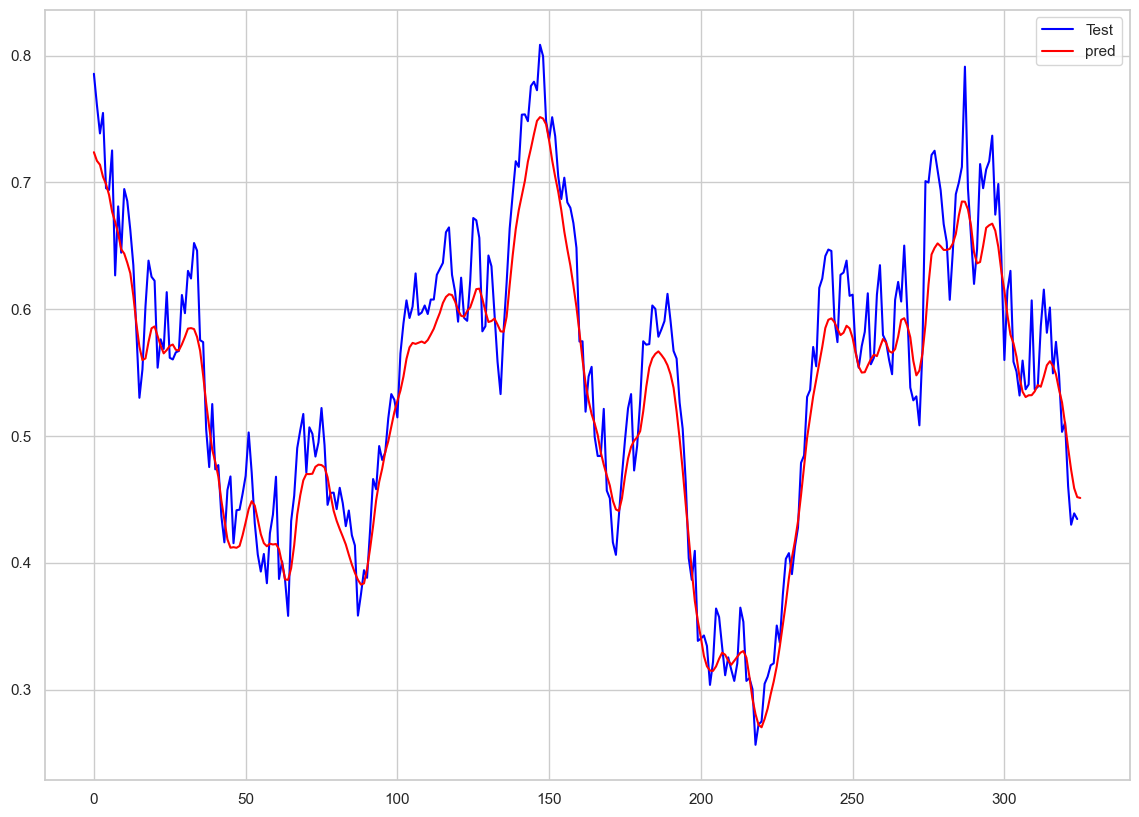

In [106]:
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()

### 6. Calculating Error metrics

In [143]:
# removing last prediction, (nan values to calculate the right metrics)
y_test = y_test[:-1]
y_pred = y_pred[:-1]

In [167]:
def MAPE(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAPE = np.nanmean(np.abs((actual - pred) / actual)) * 100
    return MAPE

def MAE(actual, pred):
    MAE = mean_absolute_error(actual, pred)
    return MAE

def RMSE(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared = False)
    return RMSE

In [157]:
MAPE(y_test, y_pred)

4.985179031542772

In [160]:
MAE(y_test, y_pred)

0.027889381389276054

In [168]:
RMSE(y_test, y_pred)

0.03415580757617934

### Next Steps:
    - Add new features: (RSI, New move metrics, standard deviation, bollinger bands)
    - test new hyperparametrs (Grid search, Random search, Hill climbing, Bayesian optimization)
    - Run versions to predict diferent targets(target next diference, target next day up/down)